Epoch [1/20], Base Ingredients Train Loss: 0.3187, Base Ingredients Train Accuracy: 0.8738, Dishes Train Loss: 2.0580, Dishes Train Accuracy: 0.3067, Base Ingredients Validation Loss: 0.2671, Base Ingredients Validation Accuracy: 0.8949, Dishes Validation Loss: 1.6717, Dishes Validation Accuracy: 0.5090, Base Ingredients Test Loss: 0.2625, Base Ingredients Test Accuracy: 0.8953, Dishes Test Loss: 1.6319, Dishes Test Accuracy: 0.5144
Epoch [2/20], Base Ingredients Train Loss: 0.2536, Base Ingredients Train Accuracy: 0.8983, Dishes Train Loss: 1.3714, Dishes Train Accuracy: 0.6406, Base Ingredients Validation Loss: 0.2357, Base Ingredients Validation Accuracy: 0.8969, Dishes Validation Loss: 1.3378, Dishes Validation Accuracy: 0.6272, Base Ingredients Test Loss: 0.2281, Base Ingredients Test Accuracy: 0.9027, Dishes Test Loss: 1.2797, Dishes Test Accuracy: 0.6390
Epoch [3/20], Base Ingredients Train Loss: 0.2284, Base Ingredients Train Accuracy: 0.9040, Dishes Train Loss: 1.0848, Dishes 

Epoch [20/20], Base Ingredients Train Loss: 0.1549, Base Ingredients Train Accuracy: 0.9361, Dishes Train Loss: 0.4295, Dishes Train Accuracy: 0.8818, Base Ingredients Validation Loss: 0.1861, Base Ingredients Validation Accuracy: 0.9140, Dishes Validation Loss: 0.8103, Dishes Validation Accuracy: 0.7384, Base Ingredients Test Loss: 0.1835, Base Ingredients Test Accuracy: 0.9208, Dishes Test Loss: 0.8569, Dishes Test Accuracy: 0.7029


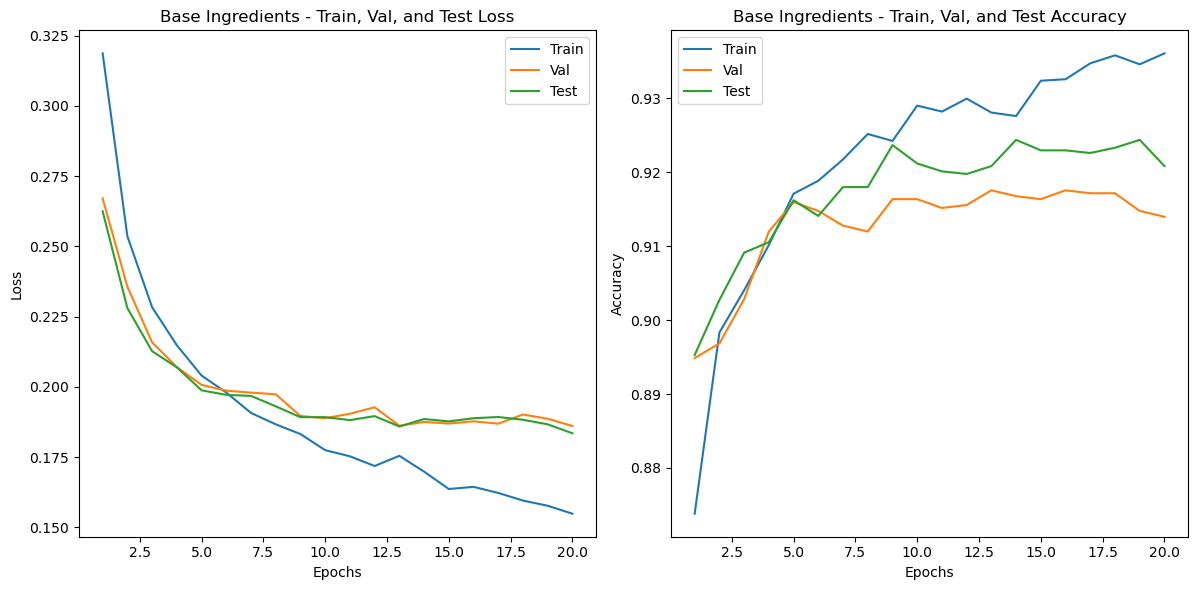

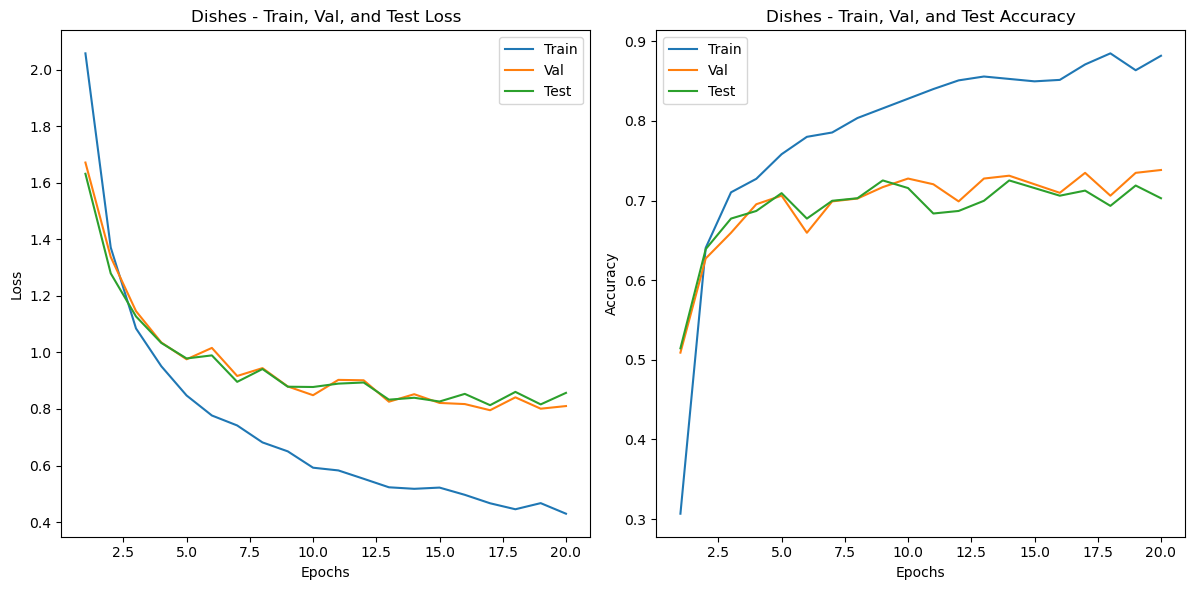

In [8]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models import resnet50, ResNet50_Weights

# Definir transformaciones de datos
transform_rgb = transforms.Compose([
    transforms.Resize((224, 224)),  # Cambiar tamaño de la imagen
    transforms.ToTensor(),  # Convertir imagen a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizar valores de los pixeles
])

# Cargar los nombres de los grupos de comida
with open("MAFood121/annotations/foodgroups.txt", "r") as f:
    food_groups = f.read().splitlines()

# Cargar los ingredientes base
with open("MAFood121/annotations/baseIngredients.txt", "r") as f:
    base_ingredients = f.read().splitlines()

# Cargar los platos de comida
with open("MAFood121/annotations/dishes.txt", "r") as f:
    dishes = f.read().splitlines()

# Crear un diccionario para mapear los nombres de los grupos de comida a sus índices correspondientes
food_groups_dict = {food_group: idx for idx, food_group in enumerate(food_groups)}

# Crear un diccionario para mapear los nombres de los ingredientes base a sus índices correspondientes
base_ingredients_dict = {ingredient: idx for idx, ingredient in enumerate(base_ingredients)}

# Crear un diccionario para mapear los nombres de los platos de comida a sus índices correspondientes
dishes_dict = {dish: idx for idx, dish in enumerate(dishes)}

# Clase para el dataset multi-label
class MAFood121MultiLabelDataset(Dataset):
    def __init__(self, txt_path, lbls_ff_txt_path, dishes_txt_path, food_groups_dict, base_ingredients_dict, dishes_dict, transform=None):
        self.txt_path = txt_path
        self.lbls_ff_txt_path = lbls_ff_txt_path
        self.dishes_txt_path = dishes_txt_path
        self.food_groups_dict = food_groups_dict
        self.base_ingredients_dict = base_ingredients_dict
        self.dishes_dict = dishes_dict
        self.transform = transform
        self.data = self._read_txt_file(txt_path)
        self.labels_ff = self._read_lbls_ff_txt_file(lbls_ff_txt_path)
        self.labels_dishes = self._read_dishes_txt_file(dishes_txt_path)

    def _read_txt_file(self, file_path):
        with open(file_path, "r") as f:
            lines = f.read().splitlines()
        return lines

    def _read_lbls_ff_txt_file(self, file_path):
        with open(file_path, "r") as f:
            lbls_ff_indices = [int(line) for line in f.read().splitlines()]
        return lbls_ff_indices

    def _read_dishes_txt_file(self, file_path):
        with open(file_path, "r") as f:
            dishes_indices = [int(line) for line in f.read().splitlines()]
        return dishes_indices

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_name = self.data[index]
        img_path = os.path.join("MAFood121/images", img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        label_ff_idx = self.labels_ff[index]
        label_ff = food_groups_dict[food_groups[label_ff_idx]]

        # Obtener los ingredientes base del foodgroup actual
        base_ingredients_idx = [base_ingredients_dict[ingredient] for ingredient in food_groups[label_ff_idx].split(',')]
        label_base_ingredients = torch.zeros(len(base_ingredients))
        label_base_ingredients[base_ingredients_idx] = 1

        # Obtener el plato de comida
        label_dish_idx = self.labels_dishes[index]
        label_dish = dishes_dict[dishes[label_dish_idx]]

        return image, label_ff, label_base_ingredients, label_dish

# Cargar los datos del conjunto de entrenamiento
train_txt_path = "MAFood121/annotations/train.txt"
train_lbls_ff_txt_path = "MAFood121/annotations/train_lbls_ff.txt"
train_dishes_txt_path = "MAFood121/annotations/train_lbls_d.txt"
train_dataset = MAFood121MultiLabelDataset(train_txt_path, train_lbls_ff_txt_path, train_dishes_txt_path,
                                          food_groups_dict, base_ingredients_dict, dishes_dict, transform_rgb)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Cargar los datos del conjunto de validación
val_txt_path = "MAFood121/annotations/val.txt"
val_lbls_ff_txt_path = "MAFood121/annotations/val_lbls_ff.txt"
val_dishes_txt_path = "MAFood121/annotations/val_lbls_d.txt"
val_dataset = MAFood121MultiLabelDataset(val_txt_path, val_lbls_ff_txt_path, val_dishes_txt_path,
                                        food_groups_dict, base_ingredients_dict, dishes_dict, transform_rgb)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Cargar los datos del conjunto de prueba
test_txt_path = "MAFood121/annotations/test.txt"
test_lbls_ff_txt_path = "MAFood121/annotations/test_lbls_ff.txt"
test_dishes_txt_path = "MAFood121/annotations/test_lbls_d.txt"
test_dataset = MAFood121MultiLabelDataset(test_txt_path, test_lbls_ff_txt_path, test_dishes_txt_path,
                                         food_groups_dict, base_ingredients_dict, dishes_dict, transform_rgb)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Definir la arquitectura del modelo multi-label utilizando ResNet-50
class MyMultiTaskModel(nn.Module):
    def __init__(self, num_food_groups, num_base_ingredients, num_dishes):
        super(MyMultiTaskModel, self).__init__()

        # Cargar el modelo ResNet-50 pre-entrenado en ImageNet
        resnet50 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        
        # Deshabilitar el entrenamiento de las capas existentes
        for param in resnet50.parameters():
            param.requires_grad = False

        # Extraer el clasificador de ResNet-50 y ajustar la salida para las clases de interés
        self.features = nn.Sequential(*list(resnet50.children())[:-1])  # Todas las capas excepto la capa de clasificación
        in_features = resnet50.fc.in_features
        
        # Capa Dropout
        self.dropout = nn.Dropout(0.1)

        self.classifier_food_groups = nn.Linear(in_features, num_food_groups)
        self.classifier_base_ingredients = nn.Linear(in_features, num_base_ingredients)
        self.classifier_dishes = nn.Linear(in_features, num_dishes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        
        # Aplicar Dropout
        x = self.dropout(x)
        
        out_food_groups = self.classifier_food_groups(x)
        out_base_ingredients = self.classifier_base_ingredients(x)
        out_dishes = self.classifier_dishes(x)
        return out_food_groups, out_base_ingredients, out_dishes

# Configuración de GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Creación del modelo y envío a GPU si está disponible
model = MyMultiTaskModel(num_food_groups=len(food_groups), num_base_ingredients=len(base_ingredients),
                         num_dishes=len(dishes))
model.to(device)

# Definición de la función de pérdida y optimizador para multi-label
criterion_food_groups = nn.CrossEntropyLoss()
criterion_base_ingredients = nn.BCEWithLogitsLoss()
criterion_dishes = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20

# Entrenamiento del modelo multitarea
train_losses_ff = []
train_losses_base = []
train_losses_dishes = []
train_accuracies_ff = []
train_accuracies_base = []
train_accuracies_dishes = []

val_losses_ff = []
val_losses_base = []
val_losses_dishes = []
val_accuracies_ff = []
val_accuracies_base = []
val_accuracies_dishes = []

test_losses_ff = []
test_losses_base = []
test_losses_dishes = []
test_accuracies_ff = []
test_accuracies_base = []
test_accuracies_dishes = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss_ff = 0.0
    running_train_loss_base = 0.0
    running_train_loss_dishes = 0.0
    correct_train_ff = 0
    correct_train_base = 0
    correct_train_dishes = 0
    total_train = 0

    for images, labels_ff, labels_base, labels_dishes in train_loader:
        images = images.to(device)
        labels_ff = labels_ff.to(device)
        labels_base = labels_base.to(device)
        labels_dishes = labels_dishes.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs_ff, outputs_base, outputs_dishes = model(images)

        # Calculate loss for each task
        loss_ff = criterion_food_groups(outputs_ff, labels_ff)
        loss_base = criterion_base_ingredients(outputs_base, labels_base)
        loss_dishes = criterion_dishes(outputs_dishes, labels_dishes)

        # Weighted sum of losses
        loss = loss_ff + loss_base + loss_dishes

        # Backward pass y optimización
        loss.backward()
        optimizer.step()

        running_train_loss_ff += loss_ff.item()
        running_train_loss_base += loss_base.item()
        running_train_loss_dishes += loss_dishes.item()

        # Calculate accuracy for each task
        _, predicted_ff = torch.max(outputs_ff.data, 1)
        correct_train_ff += (predicted_ff == labels_ff).sum().item()

        correct_train_base += torch.sum(torch.round(torch.sigmoid(outputs_base)) == labels_base).item()

        _, predicted_dishes = torch.max(outputs_dishes.data, 1)
        correct_train_dishes += (predicted_dishes == labels_dishes).sum().item()

        total_train += labels_ff.size(0)

    # Imprimir loss y accuracy promedio en cada época para el conjunto de entrenamiento
    avg_train_loss_ff = running_train_loss_ff / len(train_loader)
    avg_train_loss_base = running_train_loss_base / len(train_loader)
    avg_train_loss_dishes = running_train_loss_dishes / len(train_loader)

    avg_train_accuracy_ff = correct_train_ff / total_train
    avg_train_accuracy_base = correct_train_base / (total_train * len(base_ingredients))
    avg_train_accuracy_dishes = correct_train_dishes / total_train

    # Validación del modelo
    model.eval()
    running_val_loss_ff = 0.0
    running_val_loss_base = 0.0
    running_val_loss_dishes = 0.0
    correct_val_ff = 0
    correct_val_base = 0
    correct_val_dishes = 0
    total_val = 0

    with torch.no_grad():
        for images, labels_ff, labels_base, labels_dishes in val_loader:
            images = images.to(device)
            labels_ff = labels_ff.to(device)
            labels_base = labels_base.to(device)
            labels_dishes = labels_dishes.to(device)

            outputs_ff, outputs_base, outputs_dishes = model(images)
            loss_ff = criterion_food_groups(outputs_ff, labels_ff)
            loss_base = criterion_base_ingredients(outputs_base, labels_base)
            loss_dishes = criterion_dishes(outputs_dishes, labels_dishes)

            running_val_loss_ff += loss_ff.item()
            running_val_loss_base += loss_base.item()
            running_val_loss_dishes += loss_dishes.item()

            # Calculate accuracy for each task
            _, predicted_ff = torch.max(outputs_ff.data, 1)
            correct_val_ff += (predicted_ff == labels_ff).sum().item()

            correct_val_base += torch.sum(torch.round(torch.sigmoid(outputs_base)) == labels_base).item()

            _, predicted_dishes = torch.max(outputs_dishes.data, 1)
            correct_val_dishes += (predicted_dishes == labels_dishes).sum().item()

            total_val += labels_ff.size(0)

    # Imprimir loss y accuracy promedio en validación
    avg_val_loss_ff = running_val_loss_ff / len(val_loader)
    avg_val_loss_base = running_val_loss_base / len(val_loader)
    avg_val_loss_dishes = running_val_loss_dishes / len(val_loader)

    avg_val_accuracy_ff = correct_val_ff / total_val
    avg_val_accuracy_base = correct_val_base / (total_val * len(base_ingredients))
    avg_val_accuracy_dishes = correct_val_dishes / total_val
    
    # Prueba del modelo en el conjunto de prueba
    model.eval()
    running_test_loss_ff = 0.0
    running_test_loss_base = 0.0
    running_test_loss_dishes = 0.0
    correct_test_ff = 0
    correct_test_base = 0
    correct_test_dishes = 0
    total_test = 0

    with torch.no_grad():
        for images, labels_ff, labels_base, labels_dishes in test_loader:
            images = images.to(device)
            labels_ff = labels_ff.to(device)
            labels_base = labels_base.to(device)
            labels_dishes = labels_dishes.to(device)

            outputs_ff, outputs_base, outputs_dishes = model(images)
            loss_ff = criterion_food_groups(outputs_ff, labels_ff)
            loss_base = criterion_base_ingredients(outputs_base, labels_base)
            loss_dishes = criterion_dishes(outputs_dishes, labels_dishes)

            running_test_loss_ff += loss_ff.item()
            running_test_loss_base += loss_base.item()
            running_test_loss_dishes += loss_dishes.item()

            # Calculate accuracy for each task
            _, predicted_ff = torch.max(outputs_ff.data, 1)
            correct_test_ff += (predicted_ff == labels_ff).sum().item()

            correct_test_base += torch.sum(torch.round(torch.sigmoid(outputs_base)) == labels_base).item()

            _, predicted_dishes = torch.max(outputs_dishes.data, 1)
            correct_test_dishes += (predicted_dishes == labels_dishes).sum().item()

            total_test += labels_ff.size(0)

    # Imprimir loss y accuracy en prueba
    avg_test_loss_ff = running_test_loss_ff / len(test_loader)
    avg_test_loss_base = running_test_loss_base / len(test_loader)
    avg_test_loss_dishes = running_test_loss_dishes / len(test_loader)

    avg_test_accuracy_ff = correct_test_ff / total_test
    avg_test_accuracy_base = correct_test_base / (total_test * len(base_ingredients))
    avg_test_accuracy_dishes = correct_test_dishes / total_test
    
    print(f"Epoch [{epoch + 1}/{num_epochs}], Base Ingredients Train Loss: {avg_train_loss_base:.4f}, Base Ingredients Train Accuracy: {avg_train_accuracy_base:.4f}, Dishes Train Loss: {avg_train_loss_dishes:.4f}, Dishes Train Accuracy: {avg_train_accuracy_dishes:.4f}, "
          f"Base Ingredients Validation Loss: {avg_val_loss_base:.4f}, Base Ingredients Validation Accuracy: {avg_val_accuracy_base:.4f}, Dishes Validation Loss: {avg_val_loss_dishes:.4f}, Dishes Validation Accuracy: {avg_val_accuracy_dishes:.4f}, "
          f"Base Ingredients Test Loss: {avg_test_loss_base:.4f}, Base Ingredients Test Accuracy: {avg_test_accuracy_base:.4f}, Dishes Test Loss: {avg_test_loss_dishes:.4f}, Dishes Test Accuracy: {avg_test_accuracy_dishes:.4f}")
    
    """
    print(f"Epoch [{epoch + 1}/{num_epochs}], Food Groups Train Loss: {avg_train_loss_ff:.4f}, Food Groups Train Accuracy: {avg_train_accuracy_ff:.4f}, Base Ingredients Train Loss: {avg_train_loss_base:.4f}, Base Ingredients Train Accuracy: {avg_train_accuracy_base:.4f}, Dishes Train Loss: {avg_train_loss_dishes:.4f}, Dishes Train Accuracy: {avg_train_accuracy_dishes:.4f}, "
          f"Food Groups Validation Loss: {avg_val_loss_ff:.4f}, Food Groups Validation Accuracy: {avg_val_accuracy_ff:.4f}, Base Ingredients Validation Loss: {avg_val_loss_base:.4f}, Base Ingredients Validation Accuracy: {avg_val_accuracy_base:.4f}, Dishes Validation Loss: {avg_val_loss_dishes:.4f}, Dishes Validation Accuracy: {avg_val_accuracy_dishes:.4f}, "
          f"Food Groups Test Loss: {avg_test_loss_ff:.4f}, Food Groups Test Accuracy: {avg_test_accuracy_ff:.4f}, Base Ingredients Test Loss: {avg_test_loss_base:.4f}, Base Ingredients Test Accuracy: {avg_test_accuracy_base:.4f}, Dishes Test Loss: {avg_test_loss_dishes:.4f}, Dishes Test Accuracy: {avg_test_accuracy_dishes:.4f}")
    """      

    train_losses_ff.append(avg_train_loss_ff)
    train_losses_base.append(avg_train_loss_base)
    train_losses_dishes.append(avg_train_loss_dishes)

    train_accuracies_ff.append(avg_train_accuracy_ff)
    train_accuracies_base.append(avg_train_accuracy_base)
    train_accuracies_dishes.append(avg_train_accuracy_dishes)

    val_losses_ff.append(avg_val_loss_ff)
    val_losses_base.append(avg_val_loss_base)
    val_losses_dishes.append(avg_val_loss_dishes)

    val_accuracies_ff.append(avg_val_accuracy_ff)
    val_accuracies_base.append(avg_val_accuracy_base)
    val_accuracies_dishes.append(avg_val_accuracy_dishes)

    test_losses_ff.append(avg_test_loss_ff)
    test_losses_base.append(avg_test_loss_base)
    test_losses_dishes.append(avg_test_loss_dishes)

    test_accuracies_ff.append(avg_test_accuracy_ff)
    test_accuracies_base.append(avg_test_accuracy_base)
    test_accuracies_dishes.append(avg_test_accuracy_dishes)

# Graficar loss y accuracy en entrenamiento, validación y prueba para los tres modelos
epochs = range(1, num_epochs + 1)

"""
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses_ff, label='Train')
plt.plot(epochs, val_losses_ff, label='Val')
plt.plot(epochs, test_losses_ff, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Food Groups - Train, Val, and Test Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracies_ff, label='Train')
plt.plot(epochs, val_accuracies_ff, label='Val')
plt.plot(epochs, test_accuracies_ff, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Food Groups - Train, Val, and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
"""

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses_base, label='Train')
plt.plot(epochs, val_losses_base, label='Val')
plt.plot(epochs, test_losses_base, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Base Ingredients - Train, Val, and Test Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracies_base, label='Train')
plt.plot(epochs, val_accuracies_base, label='Val')
plt.plot(epochs, test_accuracies_base, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Base Ingredients - Train, Val, and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses_dishes, label='Train')
plt.plot(epochs, val_losses_dishes, label='Val')
plt.plot(epochs, test_losses_dishes, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Dishes - Train, Val, and Test Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracies_dishes, label='Train')
plt.plot(epochs, val_accuracies_dishes, label='Val')
plt.plot(epochs, test_accuracies_dishes, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Dishes - Train, Val, and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


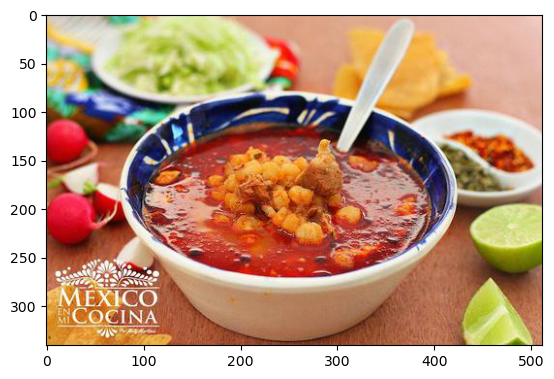

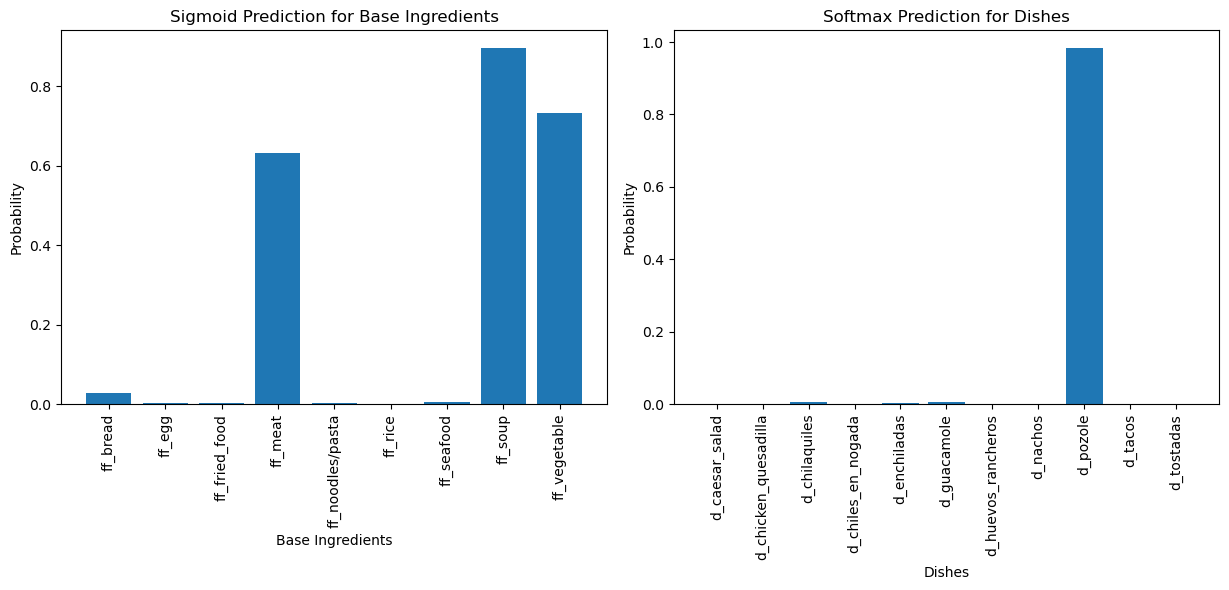


Predicciones ML, ingredients (Sigmoid):
[0.02892053 0.00210371 0.00226238 0.63108075 0.00290916 0.
 0.0047883  0.8954698  0.73154396]

Predicciones SL, dishes (Softmax):
[0.         0.         0.00448547 0.00108502 0.00371902 0.00537802
 0.         0.00115086 0.9830889  0.         0.        ]


In [9]:
# Cargar una imagen de prueba
img_path = '56_1.jpg'
img = Image.open(img_path).convert('RGB')
plt.imshow(img)

# Resize image and convert to tensor
IMG_SIZE = 224  # Tamaño de imagen esperado por ResNet-50
transform = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor()])
img = transform(img)
img = img.unsqueeze(0)

# Obtener predicciones del modelo para ambos ingredientes base, grupos de comida y plato de comida
model.eval()
with torch.no_grad():
    preds_ff, preds_base, preds_dishes = model(img.to(device))

# Aplicar softmax a las predicciones de grupos de comida
preds_ff = torch.nn.functional.softmax(preds_ff, dim=1)
preds_ff = preds_ff.cpu().numpy()

# Aplicar sigmoid a las predicciones de ingredientes base
preds_base = torch.sigmoid(preds_base)
preds_base = preds_base.cpu().numpy()

# Establecer los valores por debajo de 0.5 en 0
preds_base[preds_base < 0.001] = 0

# Aplicar softmax a las predicciones de plato de comida
preds_dishes = torch.nn.functional.softmax(preds_dishes, dim=1)
preds_dishes = preds_dishes.cpu().numpy()

# Establecer los valores por debajo de 0.2 en 0
preds_dishes[preds_dishes < 0.001] = 0

# Graficar los resultados de la predicción para ambos ingredientes base, grupos de comida y plato de comida
preds_ff = preds_ff.squeeze()
preds_base = preds_base.squeeze()
preds_dishes = preds_dishes.squeeze()

"""
plt.figure(figsize=(40, 5))
plt.subplot(1, 3, 1)
plt.bar(food_groups, preds_ff)
plt.title('Softmax Prediction for Food Groups')
plt.xticks(rotation=90)
plt.xlabel('Food Groups')
plt.ylabel('Probability')
"""

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 2)
plt.bar(base_ingredients, preds_base)
plt.title('Sigmoid Prediction for Base Ingredients')
plt.xticks(rotation=90)
plt.xlabel('Base Ingredients')
plt.ylabel('Probability')

plt.subplot(1, 3, 3)
plt.bar(dishes, preds_dishes)
plt.title('Softmax Prediction for Dishes')
plt.xticks(rotation=90)
plt.xlabel('Dishes')
plt.ylabel('Probability')

plt.tight_layout()
plt.show()

# Imprimir predicciones ML (Sigmoid) y SL (Softmax)
print("\nPredicciones ML, ingredients (Sigmoid):")
print(preds_base.squeeze())

print("\nPredicciones SL, dishes (Softmax):")
print(preds_dishes.squeeze())

In [ ]:
Sin ontología
optimizer: Adam, lr: 0.001
dropout: (0.1)
img: 56_1.jpg
img_size: 224
---------------------------

Epoch [5/5], 
Base Ingredients Train Loss: 0.2026, 
Base Ingredients Train Accuracy: 0.9174, 

Base Ingredients Validation Loss: 0.2031,     
Base Ingredients Validation Accuracy: 0.9092, 
    
Base Ingredients Test Loss: 0.2038,     
Base Ingredients Test Accuracy: 0.9137, 
    
Dishes Train Loss: 0.8455, 
Dishes Train Accuracy: 0.7642, 
    
Dishes Validation Loss: 0.9758,     
Dishes Validation Accuracy: 0.6989,
    
Dishes Test Loss: 0.9944, 
Dishes Test Accuracy: 0.6869

In [ ]:
Con ontología
optimizer: Adam, lr: 0.001
dropout: (0.1)
img: 56_1.jpg
img_size: 224
---------------------------

Epoch [5/5], 
Base Ingredients Train Loss: 0.6672, 
Base Ingredients Train Accuracy: 0.5896, 
    
Base Ingredients Validation Loss: 0.6696, 
Base Ingredients Validation Accuracy: 0.5938, 
    
Base Ingredients Test Loss: 0.6665, 
Base Ingredients Test Accuracy: 0.5932, 
    
Dishes Train Loss: 0.8532, 
Dishes Train Accuracy: 0.7564, 
    
Dishes Validation Loss: 0.9961, 
Dishes Validation Accuracy: 0.6953, 
    
Dishes Test Loss: 0.9932, 
Dishes Test Accuracy: 0.6805

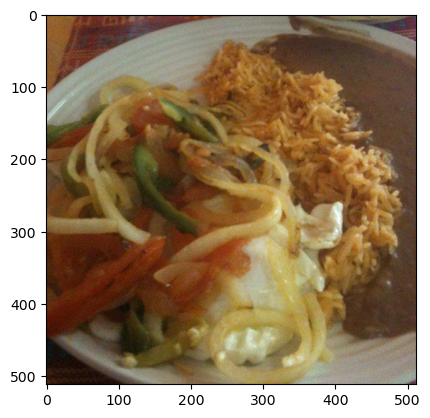

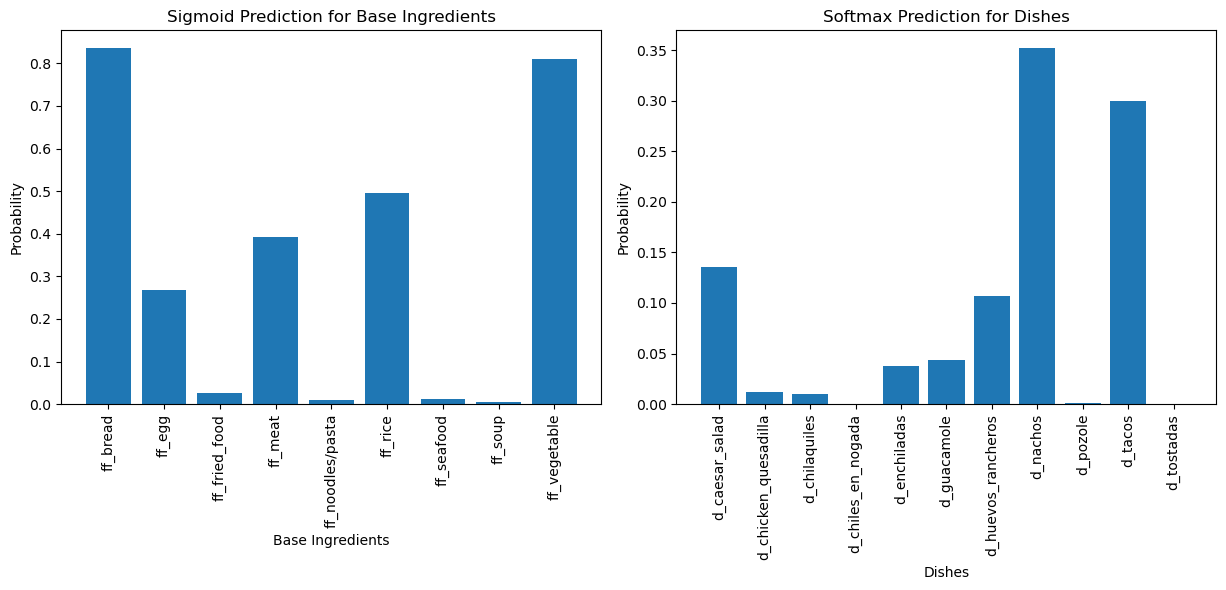


Predicciones ML, ingredients (Sigmoid):
[0.83586824 0.26794845 0.02587272 0.39297175 0.01068224 0.49551475
 0.01097892 0.00384714 0.81130606]

Predicciones SL, dishes (Softmax):
[0.13592543 0.01172795 0.0096293  0.         0.03782911 0.04350815
 0.10729653 0.35194856 0.00114479 0.29996723 0.        ]


In [11]:
# Cargar una imagen de prueba
img_path = '473481.jpg'
img = Image.open(img_path).convert('RGB')
plt.imshow(img)

# Resize image and convert to tensor
IMG_SIZE = 224  # Tamaño de imagen esperado por ResNet-50
transform = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor()])
img = transform(img)
img = img.unsqueeze(0)

# Obtener predicciones del modelo para ambos ingredientes base, grupos de comida y plato de comida
model.eval()
with torch.no_grad():
    preds_ff, preds_base, preds_dishes = model(img.to(device))

# Aplicar softmax a las predicciones de grupos de comida
preds_ff = torch.nn.functional.softmax(preds_ff, dim=1)
preds_ff = preds_ff.cpu().numpy()

# Aplicar sigmoid a las predicciones de ingredientes base
preds_base = torch.sigmoid(preds_base)
preds_base = preds_base.cpu().numpy()

# Establecer los valores por debajo de 0.5 en 0
preds_base[preds_base < 0.001] = 0

# Aplicar softmax a las predicciones de plato de comida
preds_dishes = torch.nn.functional.softmax(preds_dishes, dim=1)
preds_dishes = preds_dishes.cpu().numpy()

# Establecer los valores por debajo de 0.2 en 0
preds_dishes[preds_dishes < 0.001] = 0

# Graficar los resultados de la predicción para ambos ingredientes base, grupos de comida y plato de comida
preds_ff = preds_ff.squeeze()
preds_base = preds_base.squeeze()
preds_dishes = preds_dishes.squeeze()

"""
plt.figure(figsize=(40, 5))
plt.subplot(1, 3, 1)
plt.bar(food_groups, preds_ff)
plt.title('Softmax Prediction for Food Groups')
plt.xticks(rotation=90)
plt.xlabel('Food Groups')
plt.ylabel('Probability')
"""

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 2)
plt.bar(base_ingredients, preds_base)
plt.title('Sigmoid Prediction for Base Ingredients')
plt.xticks(rotation=90)
plt.xlabel('Base Ingredients')
plt.ylabel('Probability')

plt.subplot(1, 3, 3)
plt.bar(dishes, preds_dishes)
plt.title('Softmax Prediction for Dishes')
plt.xticks(rotation=90)
plt.xlabel('Dishes')
plt.ylabel('Probability')

plt.tight_layout()
plt.show()

# Imprimir predicciones ML (Sigmoid) y SL (Softmax)
print("\nPredicciones ML, ingredients (Sigmoid):")
print(preds_base.squeeze())

print("\nPredicciones SL, dishes (Softmax):")
print(preds_dishes.squeeze())